# Coursework 1: Gradient Descent (27 Points)
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setup


In [2]:
%pip install -q otter-grader numpy pandoc seaborn autograd memory-profiler graphviz

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Initialization Cell
%matplotlib inline
import otter
grader = otter.Notebook("mml_cw_1.ipynb")
import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
import numpy as np
rng_seed = 90

---
## Part 1 - Differentiation & Gradient Descent (16 points)

In this question, we define the following constants:

$$\boldsymbol{B}=\left(\begin{array}{cc}
4 & -2 \\
-2 & 4
\end{array}\right), \quad \boldsymbol{a}=\left(\begin{array}{l}
0 \\
1
\end{array}\right), \quad \boldsymbol{b}=\left(\begin{array}{c}
-2 \\
1
\end{array}\right)$$

We define also the following functions, which are all $\mathbb{R}^2 \rightarrow \mathbb{R}$
$$
\begin{aligned}
&f_1(\boldsymbol{x})=\boldsymbol{x}^T \boldsymbol{B} \boldsymbol{x}-\boldsymbol{x}^T \boldsymbol{x}+\boldsymbol{a}^T \boldsymbol{x}-\boldsymbol{b}^T \boldsymbol{x} \\
&f_2(\boldsymbol{x})=\cos \left((\boldsymbol{x}-\boldsymbol{b})^T(\boldsymbol{x}-\boldsymbol{b})\right)+(\boldsymbol{x}-\boldsymbol{a})^T \boldsymbol{B}(\boldsymbol{x}-\boldsymbol{a}) \\
&f_3(\boldsymbol{x})=1-\left(\exp \left(-(\boldsymbol{x}-\boldsymbol{a})^T(\boldsymbol{x}-\boldsymbol{a})\right)+\exp \left(-(\boldsymbol{x}-\boldsymbol{b})^T \boldsymbol{B}(\boldsymbol{x}-\boldsymbol{b})\right)-\frac{1}{10} \log \left|\frac{1}{100} \boldsymbol{I}+\boldsymbol{x} \boldsymbol{x}^T\right|\right)
\end{aligned}
$$
Implementations of these functions are provided below.

Throughout this exercise, we remain consistent in our convention of using row vectors for our gradients $\left( \textnormal{i.e. } \frac{\partial f_1}{\partial x}, \frac{\partial f_2}{\partial x}, \frac{\partial f_3}{\partial x} \in \mathbb{R}^{1 \times 2} \right )$. 


In [8]:
# Defined constants
B = np.array([[4, -2], [-2, 4]])
a = np.array([[0], [1]])
b = np.array([[-2], [1]])

def f1(x):
    """ Function f1 taking input x with shape (2, 1) """
    return float(x.T @ B @ x - x.T @ x + a.T @ x - b.T @ x)

def f2(x):
    """ Function f2 taking input x with shape (2, 1) """
    return float(np.cos((x - b).T @ (x - b)) + (x - a).T @ B @ (x - a))

def f3(x):
    """ Function f3 taking input x with shape (2, 1) """
    return float(1 - (np.exp(-(x - a).T @ (x - a)) + \
                 np.exp(-(x - b).T @ B @ (x - b)) - \
                 (1/10.) * np.log(np.linalg.det((1/100.) * np.identity(2) + x @ x.T))))

---
### Question 1 - Checking for the existence of Minima (2 Points)
Complete the function ```f1_check_minimum(B, a, b)``` that checks whether function $f_1$ has a minimum given certain values of **a**, **b** and diagonal **B**.

Hint: you may not need to use all three gradients

In [35]:
def f1_check_minimum(B, a, b):
    """ Write a function that returns True if function f1 has a minimum for variables B, a and b, and returns False otherwise.
        Hint: it may not be required to use all B, a and b. """
    # YOUR CODE HERE
    first_deriv_check = B[0, 0] != 1 and B[1, 1] != 1
    
    if not first_deriv_check:
        return False

    hessian = np.array([[2 * (B[0, 0] - 1), B[0, 1] + B[1, 0]],
                        [B[0, 1] + B[1, 0], 2 * (B[1, 1] - 1)]])
    eig_values = np.linalg.eigvals(hessian)
    return np.alltrue(eig_values > 0)
    

In [36]:
grader.check("1. Function 1 Minima Check")

1. Function 1 Minima Check results: All test cases passed!
1. Function 1 Minima Check - 1 message: F1 Minimum Check (with minimum) Test Passed

---
### Question 2 - Calculating Gradients (6 Points)
#### Question 2.a - Method of Finite Differences (2 Points)
Remember (animation in lectures) that a gradient is found by taking
$$ \lim _{\Delta x \rightarrow 0} \frac{f(x+\Delta x)-f(x)}{\Delta x} $$
We can approximate this by calculating the expression for a small but finite $\Delta x$ along each dimension, which
is known as the _finite-differences_ approximation.

Complete the function ```grad_fn(fn, x)``` such that it returns the gradients for any function ```fn``` at a point **x** using the method of finite differences. Use a delta of $1\times 10^{-5}$.

_The function should take a columnar numpy (2, 1) vector for ‘x’ as input, and output a
numpy (1, 2) row vector for the gradient._

In [39]:
def grad_fd(fn, x, delta=1e-5):
    """ General function that calculates gradient of some 2d function at point x,
        using finite-differences.

    Inputs:
            fn: Function taking input x and returns a scalar
            x: Numpy vector of shape (2, 1)
            delta: Finite-difference delta (epsilon) used for approximation

    Returns: Approximated gradient at point x, in shape (1, 2)
    """
    dfdx = np.zeros((1, 2))
    delta_0 = np.array([[delta], [0]])
    delta_1 = np.array([[0], [delta]])
    dfdx[0, 0] = (fn(x + delta_0) - fn(x)) / delta
    dfdx[0, 1] = (fn(x + delta_1) - fn(x)) / delta
    return dfdx

In [40]:
grader.check("2.a Method of Finite Differences")

2.a Method of Finite Differences results: All test cases passed!
2.a Method of Finite Differences - 1 message: Finite Differences on f1 Test Passed
2.a Method of Finite Differences - 2 message: Finite Differences on f2 Test Passed

---
#### Question 2.b - Analytical Gradients (4 Points)
Complete the functions ```f1_grad(x)```, ```f2_grad(x)``` and ```f3_grad(x)``` that return
gradients of f1, f2 and f3, using your own derivations.

_The functions should take a columnar numpy (2, 1) vector for **x** as input, and output a
numpy (1, 2) row vector for the gradient_

In [41]:
def f1_grad_exact(x):
    """ Return gradient of f1, exactly derived by hand """
    # YOUR ANSWER HERE
    gradient = 2 * B @ x - 2 * x + a - b
    return gradient.T

In [42]:
grader.check("Q2.b.i Gradients of the Functions - f1")

Q2.b.i Gradients of the Functions - f1 results: All test cases passed!
Q2.b.i Gradients of the Functions - f1 - 1 message: Exact Gradients of f1 Test Passed

In [43]:
def f2_grad_exact(x):
    """ Return gradient of f2, exactly derived by hand """
    # YOUR ANSWER HERE
    gradient = - 2 * np.sin((x - b).T @ (x - b)) * (x - b) + 2 * B @ (x - a)
    return gradient.T

In [44]:
grader.check("Q2.b.ii Gradients of the Functions - f2")

Q2.b.ii Gradients of the Functions - f2 results: All test cases passed!
Q2.b.ii Gradients of the Functions - f2 - 1 message: Exact Gradients of f2 Test Passed

In [45]:
def f3_grad_exact(x):
    """ Return gradient of f3, exactly derived by hand """
    gradient = 2 * (x - a) * np.exp(-(x - a).T @ (x - a)) + \
        2 * B @ (x - b) * np.exp(-(x - b).T @ B @ (x - b)) + \
        x / (10 * 50 * np.linalg.det((1/100) * np.identity(2) + x @ x.T))
    return gradient.T

In [46]:
grader.check("Q2.b.iii Gradients of the Functions - f3")

Q2.b.iii Gradients of the Functions - f3 results: All test cases passed!
Q2.b.iii Gradients of the Functions - f3 - 1 message: Exact Gradients of f2 Test Passed

---
### Question 3 - Gradient Descent (8 Points)
Use your gradients to implement a gradient descent algorithm with 50 iterations
to find a local minimum for both f2 and f3, by finishing the function grad descent(fn,
grad fn).

For visualizing (and debugging) your gradient descent function, we provide some plotting code. This is contained in the cell below, so be sure to exectue it. You can use this function on f1 by passing in the other functions, for example: ```plot_grad_descent(f1, f1_grad_exact, gradient_descent)``` once you have completed the ```gradient_descent(fn, grad_fn)``` function. You can also pass in ```xrange=(x_min, x_max)``` and likewise for ```yrange``` to adjust the plotted region.

In [47]:
# Provide function for plotting gradient descent
import matplotlib.pyplot as plt
def plot_grad_descent(fn, fn_grad, gradient_descent_fn, xrange=(-1, 1), yrange=(-1,1), **kwargs):
    title = 'Plotting function #'+ fn_grad.__name__.split('_')[0][-1]
    # Define plotting range for x- and y- axis.
    x1min, x1max = xrange
    x2min, x2max = yrange

    # Evaluate function everywhere within the defined range for the contour plot
    x1 = np.linspace(x1min, x1max, 100)
    x2 = np.linspace(x2min, x2max, 100)

    X1, X2 = np.meshgrid(x1, x2)

    Y = [fn(np.array([[p1], [p2]])) for p1, p2 in zip(X1.flatten(), X2.flatten())]
    Y = np.array(Y).reshape(X1.shape)

    # Plot contour
    plt.title(title)
    plt.xlim(x1min, x1max)
    plt.ylim(x2min, x2max)
    plt.contourf(X1, X2, Y)
    plt.colorbar()

    # Plot gradient descent trajectory
    trajectory, found_minimum, found_minimum_value = gradient_descent_fn(fn, fn_grad, **kwargs)

    p1, p2 = zip(*trajectory)
    plt.plot(p1, p2, '.-', color='red')

#### Question 3.a - Implementing Gradient Descent (4 Points)
Complete the ```gradient_descent``` function below.

In [48]:
def gradient_descent(fn, grad_fn, start_x=3.0, start_y=3.0, lr=0.001, n_steps=50, silent=False):
    """ Function that performs gradient descent.

    Inputs: 
        - fn: Function to minimize
        - grad_fn: Function that returns gradient of the function to minimize
        - start_loc: Initial location
        - lr: The learning rate
        - n_steps: Number of steps
        - silent: prevent print statement (for testing)

    Returns: Tuple containing:
        - trajectory of found points: a list containing numpy (2, 1) column vectors
        - final minimum point: a numpy (2, 1) column vector
        - the value at the minimum: float
    """

    start_loc = np.array([[start_x], [start_y]])
    trajectory = [start_loc]

    for _ in range(n_steps):
        trajectory.append(trajectory[-1] - lr * grad_fn(trajectory[-1]).T)

    found_minimum_loc = trajectory[-1]
    found_minimum_value = fn(trajectory[-1])
    if not silent:
        print(f"Gradient descent found minimum value {found_minimum_value:.2f} at {found_minimum_loc.T}^T")
    return trajectory, found_minimum_loc, found_minimum_value

Gradient descent found minimum value 8.37 at [[1.52521573 1.70982674]]^T


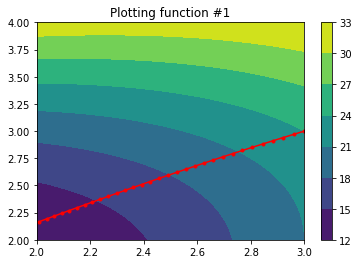

In [49]:
# Here we'll use the plotting function and specify custom starting points and plotting ranges
plot_grad_descent(f1, f1_grad_exact, gradient_descent,
                  xrange=(2, 3), yrange=(2, 4),
                  start_x=3, start_y=3, lr=0.005
)

**Note** The last two tests should be run after the first one

In [50]:
grader.check("Gradient Descent")

Gradient Descent results: All test cases passed!
Gradient Descent - 1 message: Gradient Descent Trajectory Test Passed
Gradient Descent - 2 message: Gradient Descent Minimum Location Test Passed
Gradient Descent - 3 message: Gradient Descent Minimum Value Test Passed

#### Question 3.b - Choosing Good Initializations (2 Points)


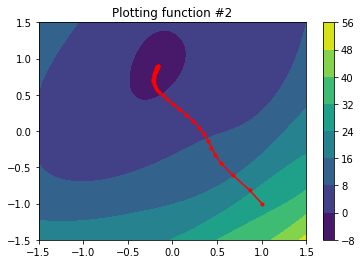

In [51]:
# Here we'll use the plotting function and specify custom starting points and plotting ranges
# For F2 
f2_start_x = 1
f2_start_y = -1
f2_lr = 0.01
f2_n_steps = 50

plot_grad_descent(f2, f2_grad_exact, gradient_descent,
                  xrange=(-1.5, 1.5), yrange=(-1.5, 1.5),
                  start_x=f2_start_x, start_y=f2_start_y, lr=f2_lr, n_steps=f2_n_steps, silent=True
)

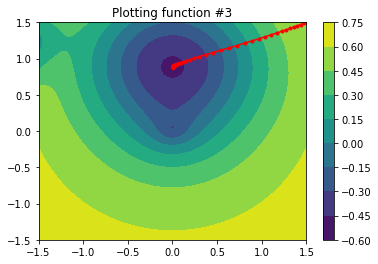

In [56]:
# For F3 
f3_start_x = 1.5
f3_start_y = 1.5
f3_lr = 0.1
f3_n_steps = 50

plot_grad_descent(f3, f3_grad_exact, gradient_descent,
                  xrange=(-1.5, 1.5), yrange=(-1.5, 1.5),
                  start_x=f3_start_x, start_y=f3_start_y, lr=f3_lr, n_steps=f3_n_steps, silent=True
)

In [57]:
grader.check("Gradient Descent Initialization")

Gradient Descent Initialization results: All test cases passed!

#### Question 3.c - Failure to Converge (2 Points)
Find an example of diverging behaviour and describe three ways that we can encourage convergence in practice.

<!-- BEGIN QUESTION -->



In [58]:
# Example of diverging behaviour
# plot_grad_descent(...)

**Answer:**

ANSWER HERE - you 

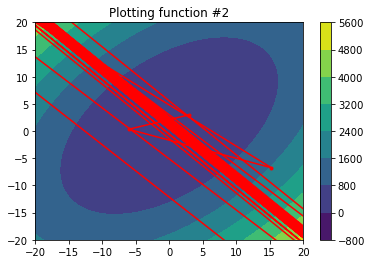

In [59]:
plot_grad_descent(f2, f2_grad_exact, gradient_descent, lr=0.4, n_steps=50, silent=True, xrange=(-20, 20), yrange=(-20, 20))

## What is meant by convergence? (Getting to one point, or getting to the global optimum)

There are a few techniques to encourage convergence in practice. I list three of them:
1. Learning rate decaying. With this technique, the learning rate decays (i.e., gets smaller) as the the descent progresses.
    This technique has empirically shown better optimization and generalization.
2. Learning rate momentum to get out of local optima (**EXPLAIN**)
3. Repeat GD for different initializations (**EXPLAIN**)

##### <!-- END QUESTION -->

---
## Part 2 - Automatic Differentation (11 Points)

In the previous part you saw how you can implement gradient descent to optimize functions by using either approximate or analytical gradients. Luckily for us, there are framework which implement derivatives for most functions we might typically care about, and which allow us to differentiate through arbitrary compositions of these functions by using **Automatic Differentiation** (autodiff). Indeed, you may already have encountered frameworks such as PyTorch, TensorFlow or Jax which have robust autodiff implementations.

In this part we'll demonstrate the power of autodiff through the [autograd](https://github.com/HIPS/autograd) library which provides a clean interface for automatically differentiating over numpy functions. Let's start by taking a look at the syntax for computing gradients in autograd:

In [120]:
from autograd import grad 
import autograd.numpy as np # Autograd wraps numpy to support automatic differentiation
# Note that particularly niche numpy functions may not be supported by autograd

# Consider the sum of squares function
def xsq(x): 
    return np.sum(x**2)

# We know the gradient of this! 
def our_grad_of_xsq(x):
    return 2*x

x = np.random.rand(4)

# We can wrap functions with grad to get the gradient function
autograd_grad_of_xsq = grad(xsq, 0) # 0 => want the gradient with respect to the first argument

# Evaluate gradients at x and check that they're the same
print(autograd_grad_of_xsq(x))
print(our_grad_of_xsq(x))

[0.63596636 0.82852599 0.12829499 1.38494424]
[0.63596636 0.82852599 0.12829499 1.38494424]


---
### Question 4 - Squared Distances and Automatic Differentiation
Although we can see that autograd is perfectly capable of computing derivatives by itself, there may be instances where the derivative of a non-elementary function is analytically *more efficient* than the composition of the gradients of its components. This means that we are better off telling autograd to use our derivate when it performs automatic differentation (sometimes we might also use esoteric functions which don't even have an existing derivate, in which case we are forced to provide one).

#### Question 4.a - Forward Pass of the Squared Distances function (1 Point)
In particular, we'll consider the gradient of 
$$ \vec{s} = \vec{p}^T \mathbf{D} \vec{q}, $$
with respect to $\vec{z}$, where $\vec{p}$ and $\vec{q}$ are constants, and $\mathbf{D}$ is the matrix of squared distances between elements of $\vec{z}$:
$$ D_{ij} = \exp(-(z_i - z_j)^2). $$

Get warmed up by implementing the the function ```sq_dist_fwd(p,q,x)``` which computes $\vec{s}$.

In [121]:
import autograd.numpy as np
from autograd import grad
np.random.seed(0)

# Naive solution
p = np.random.rand(4)
q = np.random.rand(4)
def sq_dist_fwd(p,q,x):
    """ Compute the inner product of p and q, projected through a matrix consisting of the 
        squared distance between elements of a variable x. All vectors are length x.shape[0].
        To be compatible with autograd, we need to avoid using assignments on array indices 
    """
    
    N = x.shape[0]
    assert N % 2 == 0 # We expect even numbers of elements
    assert x.shape[0] == p.shape[0] == q.shape[0]
    
#     D = np.tile(x.T, (x.shape[0], 1))
#     D = np.exp(-(D - x.reshape(x.shape[0], 1)) ** 2)
    z = np.array([x])
    D = np.exp(-(z - z.T) ** 2)

    out = p.T @ D @ q
    
    return out 

In [122]:
grader.check("Q4.a Squared Distance Function")

Q4.a Squared Distance Function results: All test cases passed!
Q4.a Squared Distance Function - 1 message: Squared Distance Function Output Shape Test Passed

#### Question 4.b - Analytical Derivate of Squared Distances (2 Points)
In order to override autograd's gradient for our squared distance function, we need to derive it ourselves - compute the derivate
$$\frac{\partial \vec{s}}{\partial \vec{z}} =\sum_{i j} a_i b_j \frac{\partial D_{i j}}{\partial \vec{z}} $$
with respect to one element of $\vec{z}$


<!-- BEGIN QUESTION -->

**Answer:**

$$\frac{\partial \vec{s}}{\partial \vec{z_n}} = 2 \cdot \sum_{i j} a_i \cdot b_j \cdot (z_i - z_j) \cdot D_{ij} \cdot (\delta_{in} - \delta_{nj}) $$

where $\delta_{ij}$ is defined as the Kronecker delta:

$$
\delta_{ij} = 
\begin{cases}
    1 & \text{if $i = j$}\\
    0 & \text{if $i \neq j$}
\end{cases}
$$

<!-- END QUESTION -->

#### Question 4.c - Implement the Derivative (2 Points)
With the analytical derivate in hand, complete the ```sq_dist_grad_elem(a, b, x, z)``` function which computes the gradient with respect to the $n^{th}$ dimension of $\vec{z}$ and the corresponding function ```sq_dist_grad``` which computes the gradient vector.



In [123]:
def kron_delt(i, j):
    return int(i == j)

In [162]:
# Autograd solution
def sq_dist_grad_elem(p, q, z, n):
    acc = 0
    for i in range(p.shape[0]):
        for j in range(p.shape[0]):
            acc += p[i] * q[j] * (z[i] - z[j]) * (- np.exp(- (z[i] - z[j]) ** 2)) * (kron_delt(i, n) - kron_delt(n, j))
    
    return 2 * acc

def sq_dist_grad(p, q, z):
    grad = np.zeros(p.shape[0])
    for i in range(p.shape[0]):
        grad[i] = sq_dist_grad_elem(p, q, z, i)
    return grad

print(sq_dist_grad(p, q, z))
print(grad(sq_dist_fwd, 2)(p, q, z))

[ 2.20607739  1.67898674 -1.92459142 -1.9604727 ]
[ 2.20607739  1.67898674 -1.92459142 -1.9604727 ]


In [163]:
grader.check("Q4.c Squared Distance Function Gradients")

Q4.c Squared Distance Function Gradients results: All test cases passed!
Q4.c Squared Distance Function Gradients - 1 message: Squared Distance Gradient Function Shape Test Passed

#### Question 4.d - Automatic Differentiation (2 Points)

Armed with our superior gradient function for the sum of squared distances, let's tell autograd to use it, and convince ourselves that all our hardwork was worthwhile!

First, let's compare memory usage to check whether our implementation actually requires less memory:

In [164]:
%load_ext memory_profiler
p,q,z = np.random.randn(200), np.random.randn(200), np.random.randn(200)
print('Ours: ', end=' ')
%memit sq_dist_grad(p,q,z)
print('Theirs:', end=' ')
%memit grad(sq_dist_fwd, 2)(p,q,z) 

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
Ours:  peak memory: 160.28 MiB, increment: 0.00 MiB
Theirs: peak memory: 160.28 MiB, increment: 0.00 MiB


You should see that our implementation of the gradient function requires considerably less memory than the one autograd provides by using autodiff. 

Now let's tell autograd to use our analytically derived gradient function when computing autodiff for a more complicated function:
$$ \vec{y} = \vec{s} = \vec{p}^T \mathbf{D}(\vec{z}) \vec{q}, \quad \text{and} \quad \vec{z} = 3\sin{x}+5$$

We'll start by revisiting our toy example of $x^2$.

In [165]:
from autograd.extend import primitive, defvjp
# First we'll consider the x squared example again

@primitive # This tells autograd we will define the gradient ourselves
def xsq(x): 
    return np.sum(x**2)

# Here's an example of how to define a custom backward pass gradient function
def xsq_vjp(ans, x):
    """ This should return a function which takes the gradient (g) of the SUBSEQUENT function
        and combines it with the gradient of the function we're differentiating 
        (i.e. propagating the accumulated gradient backwards through the graph)
    """
    print('We are constructing the computational graph')

    def xsq_vjp_inner(g):
        print('We are auto differentiating')
        print(f'gradient in was {g}, answer in was {ans}\n')
        return 2*x*g
    
    print('The gradient function has been stored in the graph \n')
    return xsq_vjp_inner

defvjp(xsq, xsq_vjp)

print('Gradient out: ', grad(xsq)(np.array([1., 2., 3.])))

We are constructing the computational graph
The gradient function has been stored in the graph 

We are auto differentiating
gradient in was 1.0, answer in was 14.0

Gradient out:  [2. 4. 6.]


Now let's apply the same idea to our squared distance function

In [166]:
from functools import partial 
# We'll overwrite the naive solution with a primitive
# to make life easier let's fix p and q with "partial"
p,q,z = np.random.randn(4), np.random.randn(4), np.random.randn(4)
sq_dist_fwd_wrapped = partial(sq_dist_fwd, p, q)
sq_dist_grad_wrapped = partial(sq_dist_grad, p, q)

@primitive 
def sq_dist(z):
    return sq_dist_fwd_wrapped(z)

def sq_dist_vjp(ans, z): 
    # Return a function which takes the gradient (g) of the SUBSEQUENT function
    # and combines it with the gradient of sq_dist
    def sq_dist_vjp_inner(g):
        return sq_dist_grad_wrapped(z) * g
    
    return sq_dist_vjp_inner

defvjp(sq_dist, sq_dist_vjp)

In [167]:
grader.check("Q4.d Squared Distance Autodiff")

Q4.d Squared Distance Autodiff results: All test cases passed!
Q4.d Squared Distance Autodiff - 1 message: Squared Distance Autodiff Value Test Passed

In [135]:
# consider the function
x = np.random.rand(4)
z = np.sin(x)*3 + 5
y = sq_dist(z)

# we can compute the gradient of y with respect to x using autograd
def complete_function(x):
    z = np.sin(x)*3 + 5
    return sq_dist(z) # This will now use our gradient function!

grad(complete_function)(x)

array([-1.56241638, -2.33509568,  0.89602532,  2.29044627])

#### Question 4.e - Understanding Autodiff (4 Points)
Now that we've seen how to define custom gradients for autodiff, let's double check our understanding:
1. Draw the computational graph for the ```complete_function(x)``` above
2. Estimate the Memory and Time complexity of the autodiff gradient calculation, and compare this to ours

<!-- BEGIN QUESTION -->



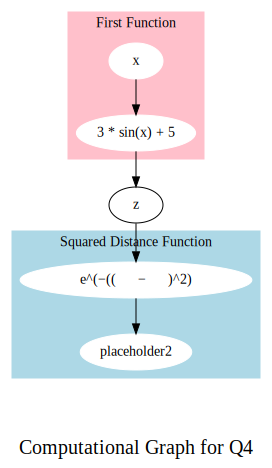

In [168]:
"""Question 4.e.i - Create a (rough) computational graph for the function"""
from graphviz import Digraph
comp_graph = Digraph('Computational Graph') # Create Digraph object

with comp_graph.subgraph(name='cluster_0') as c:
    c.attr(style='filled', color='pink', label='First Function')
    c.node_attr.update(style='filled', color='white')
    c.edges([('x', '3 * sin(x) + 5')])

with comp_graph.subgraph(name='cluster_1') as c:
    c.attr(style='filled', color='lightblue', label='Squared Distance Function')
    c.node_attr.update(style='filled', color='white')
    c.edges([('e^(−((𝑧𝑖−𝑧𝑗)^2)', 'placeholder2')])
    
comp_graph.node('z')
comp_graph.edge('3 * sin(x) + 5', 'z')
comp_graph.edge('z', 'e^(−((𝑧𝑖−𝑧𝑗)^2)')

comp_graph.attr(label=r'\n\nComputational Graph for Q4')
comp_graph.attr(fontsize='20')
comp_graph 

**Question 4.e.ii - Complexity Answer:**


<!-- END QUESTION -->

---
## Submission
Once you have completed all questions and re-ran all tests, simply push your final notebook to gitlab. You'll want to go to the [LabTS Exercise](https://teaching.doc.ic.ac.uk/labts/lab_exercises/2223/exercises/732/exercise_summary) and check that there are no strange bugs on our end - note that the test results you see on LabTS should be identical to the tests provided in this notebook; of course, we also have other tests which will be run for marking purposes :) 

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [137]:
grader.check_all()

1. Function 1 Minima Check results: All test cases passed!
1. Function 1 Minima Check - 1 message: F1 Minimum Check (with minimum) Test Passed

2.a Method of Finite Differences results: All test cases passed!
2.a Method of Finite Differences - 1 message: Finite Differences on f1 Test Passed
2.a Method of Finite Differences - 2 message: Finite Differences on f2 Test Passed

Gradient Descent results: All test cases passed!
Gradient Descent - 1 message: Gradient Descent Trajectory Test Passed
Gradient Descent - 2 message: Gradient Descent Minimum Location Test Passed
Gradient Descent - 3 message: Gradient Descent Minimum Value Test Passed

Gradient Descent Initialization results: All test cases passed!

Q2.b.i Gradients of the Functions - f1 results: All test cases passed!
Q2.b.i Gradients of the Functions - f1 - 1 message: Exact Gradients of f1 Test Passed

Q2.b.ii Gradients of the Functions - f2 results: All test cases passed!
Q2.b.ii Gradients of the Functions - f2 - 1 message: Exact G